In [99]:
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr, chi2_contingency,  pearsonr
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.patches as mpatches

In [78]:
raw_data_df = pd.read_csv('data/bank-direct-marketing.csv', sep= ';')
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

A first glance at the columns shows four columns not detailed on the website provided, these apear to be social and economic context features:

Emp.var.rate (float): Employment variation rate - Percentage of population unemployed but actively seeking work.

cons.price.idx (float): Consumer Price Index - Average price change for consumer goods, usually a basket of goods is used.

cons.conf.idx (float): Consumer Confidence Index - Seintiment based on questionaire given to consumers (usually a positive value so may tabe the absolute however most algorithms should be uneffected).

euribor3m (float): Euribor (Euro Interbank Offered Rate) 3 month rate - Daily reference rate based on the averaged interest rates Eurozone banks lend to other banks (Widely used benchmark for interest rates).

nr.employed (float): Number of employees.


In [5]:

raw_data_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


Possible outlier exists in the duration column, the pdays column may be of little use for values of 999 as this suggests that no contact was ever made again. Lets look at the distribution of the columns and then plot each of the columns against the target variable.


In [69]:
def plot_histograms(dataframe: pd.DataFrame)-> matplotlib.figure.Figure:
    """
    Plot histograms of the value counts for each column in a single figure.

    This function takes a pandas DataFrame and plots a histogram for the value
    counts of each column in a single matplotlib figure, with one subplot per
    column. The histograms are displayed inline and the figure is returned for
    further manipulation if required.

    Args:
    dataframe (pd.DataFrame): The data frame for which the histograms are to be
                                plotted.

    Returns:
    matplotlib.figure.Figure: The matplotlib figure object containing the
                                      histograms.
    
    Note:
    Each histogram is normalized to show the frequency distribution of the values.
    """
    num_columns = len(dataframe.columns)
    rows = int(np.ceil(np.sqrt(num_columns)))
    cols = int(np.ceil(num_columns / rows))

  
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.flatten() 


    for ax, col in zip(axes, dataframe.columns):

        ax.hist(dataframe[col].dropna(), bins=30, edgecolor='black', alpha=0.7)
        ax.set_title(f'Value Counts of {col}', fontsize=10)
        ax.set_xlabel('Value', fontsize=8)
        ax.set_ylabel('Frequency', fontsize=8)
        for label in ax.get_xticklabels():
            label.set_rotation(90)
        num_nans = dataframe[col].isna().sum()
        text_box_str = f'NaNs: {num_nans}'
        ax.text(0.95, 0.95, text_box_str, transform=ax.transAxes, fontsize=8,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='gray', alpha=0.5))
    
    for ax in axes[num_columns:]:
        ax.remove()


    plt.tight_layout()
    

    return fig


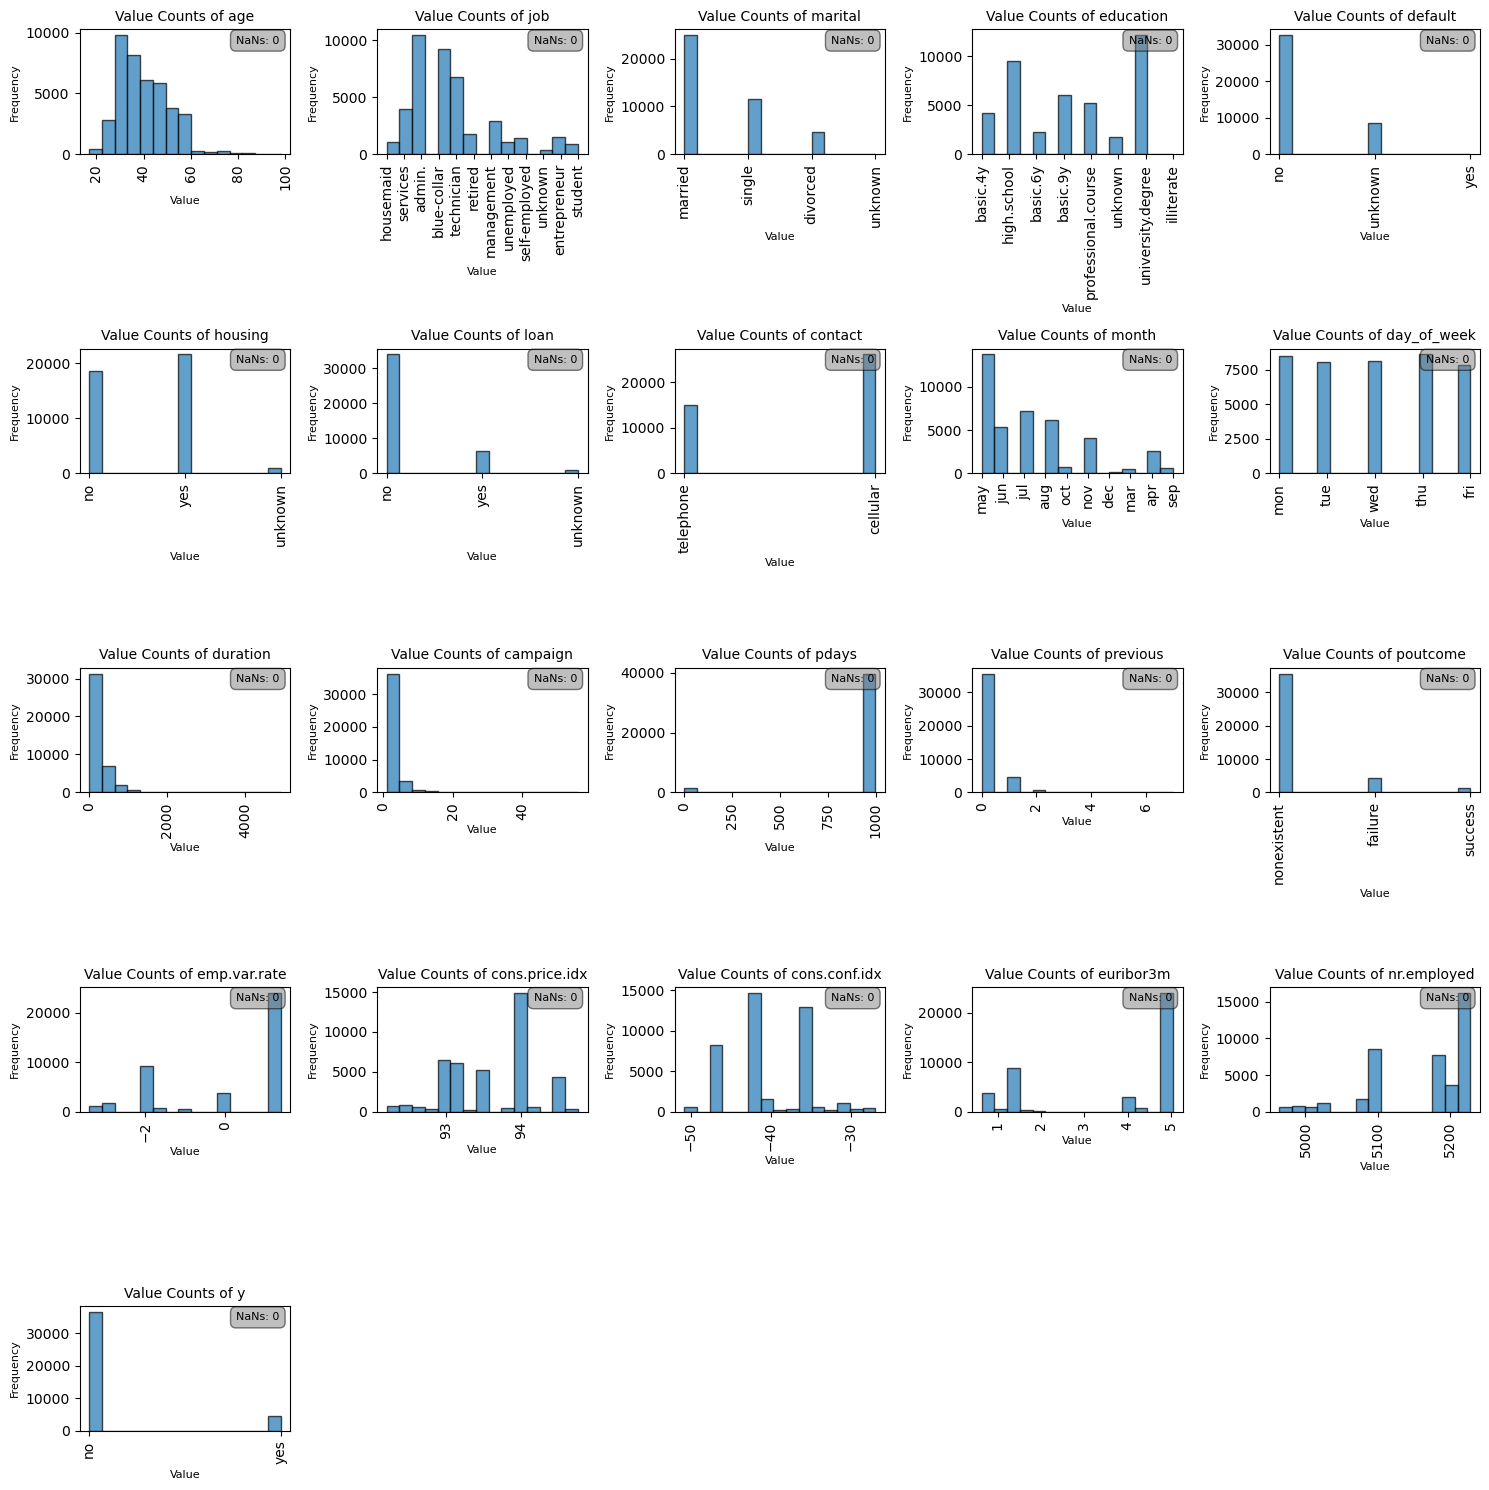

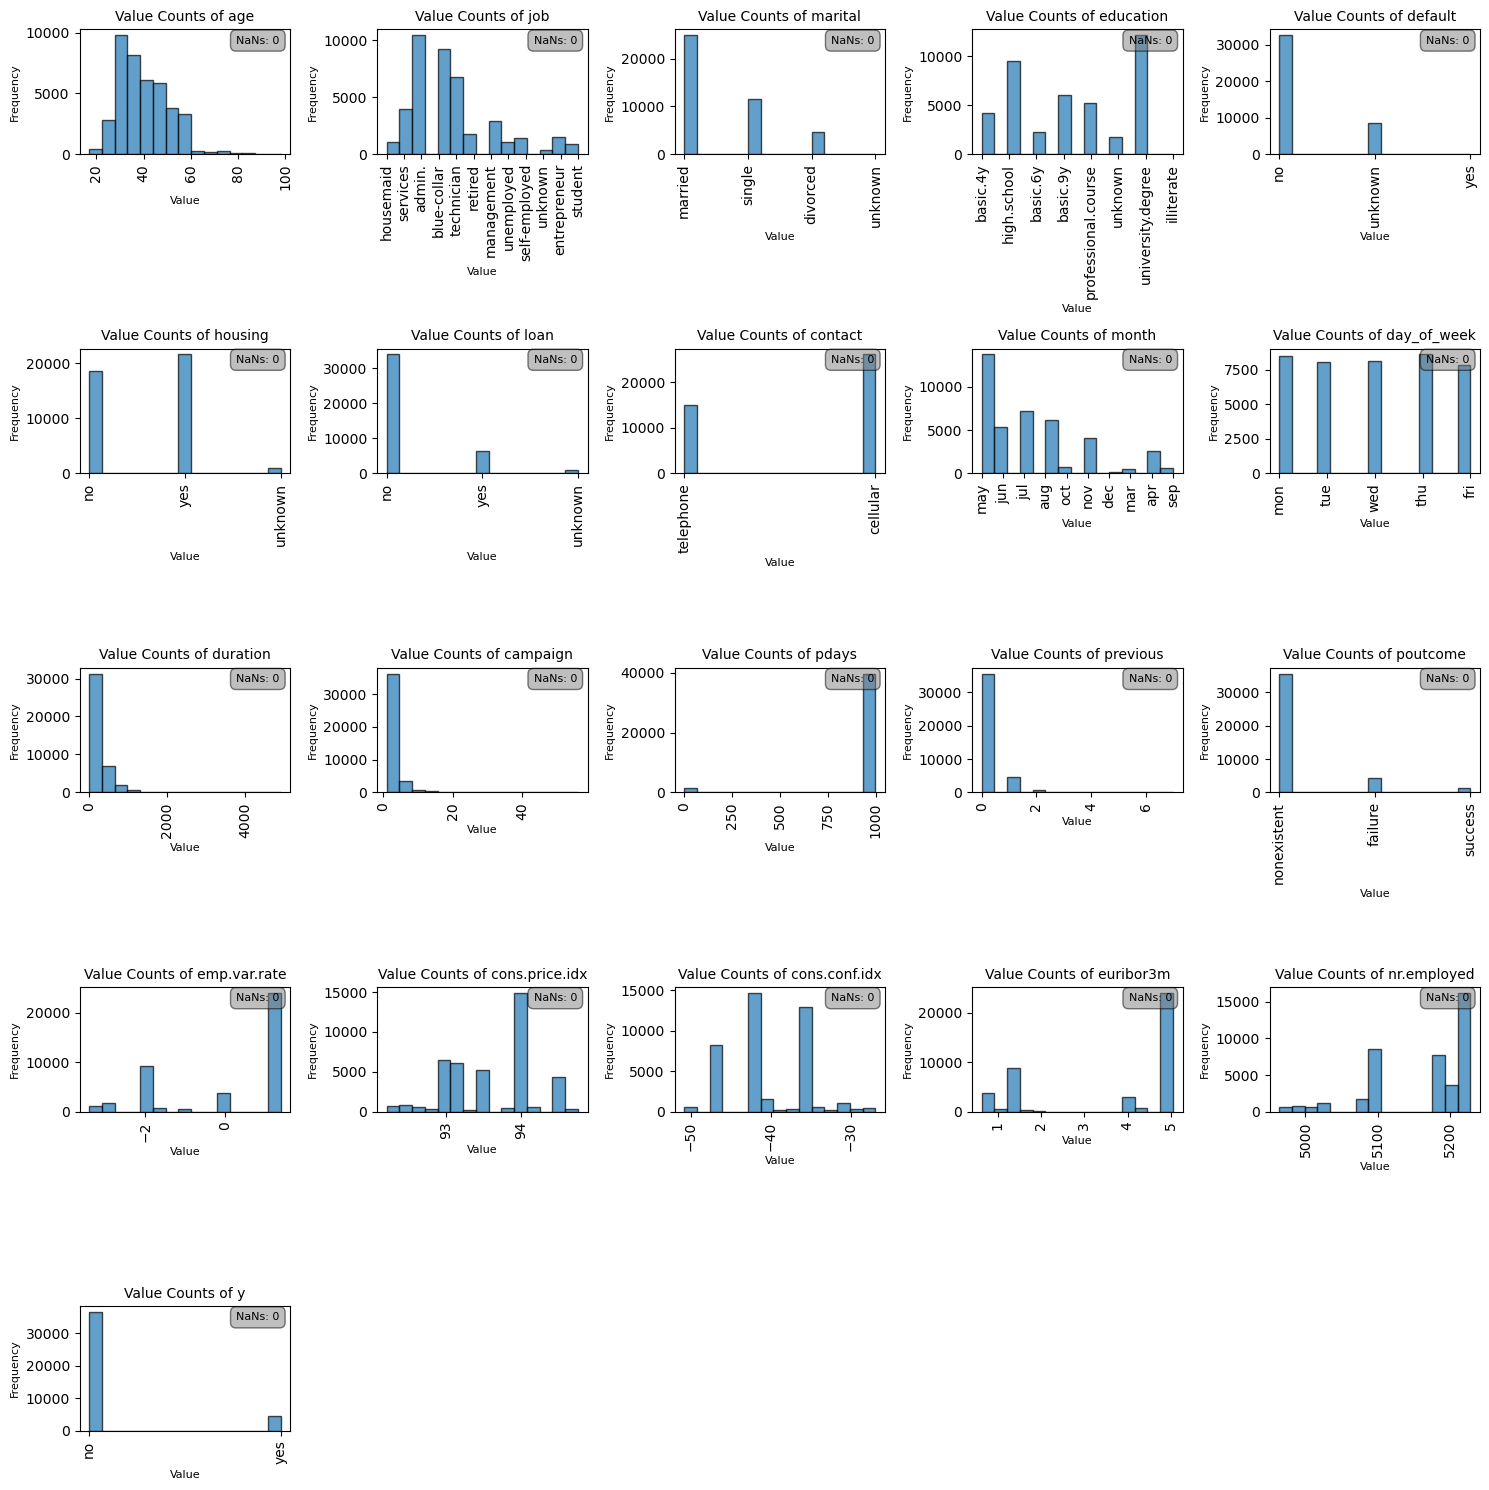

In [7]:
plot_histograms(raw_data_df)

Looking at the above the extreme duration values noted earlier do appear to be outliers and as such it will likely be best to exclude these values, tests will be conducted with an without the value included. Lets now look at the correlation scores and the target variable comapared to each fo the columns.
This also points out the large class disbakance in this data, this is likely going to show up in any evaluation metrics as false negatives, there are several solutions to this problem but they will be explored in preprocessing.

In [94]:
def plot_boxs(dataframe: pd.DataFrame)-> matplotlib.figure.Figure:
    """
    Plot box plots for each continous column in a single figure.

    This function takes a pandas DataFrame and plots a box plot for each 
    column in a single matplotlib figure, with one subplot per column. 
    The box plots are displayed inline and the figure is returned for
    further manipulation if required.
 
    Args:
    dataframe (pd.DataFrame): The data frame for which the box plots are to be
                                plotted.

    Returns:
    matplotlib.figure.Figure: The matplotlib figure object containing the
                                      box plots.
    

    """
    num_columns = dataframe.select_dtypes(include=['float64', 'int64']).shape[1]
    rows = int(np.ceil(np.sqrt(num_columns)))
    cols = int(np.ceil(num_columns / rows))

  
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.flatten() 


    for ax, col in zip(axes, dataframe.select_dtypes(
        include=['float64', 'int64']).columns):

        dataframe.boxplot(col, ax=ax)
        ax.set_title(f'Box Plot for {col}')
        ax.set_ylabel('Values', fontsize=8)
        ax.grid(False)
    plt.tight_layout()  
    
    for ax in axes[num_columns:]:
        ax.remove()
    
    return fig

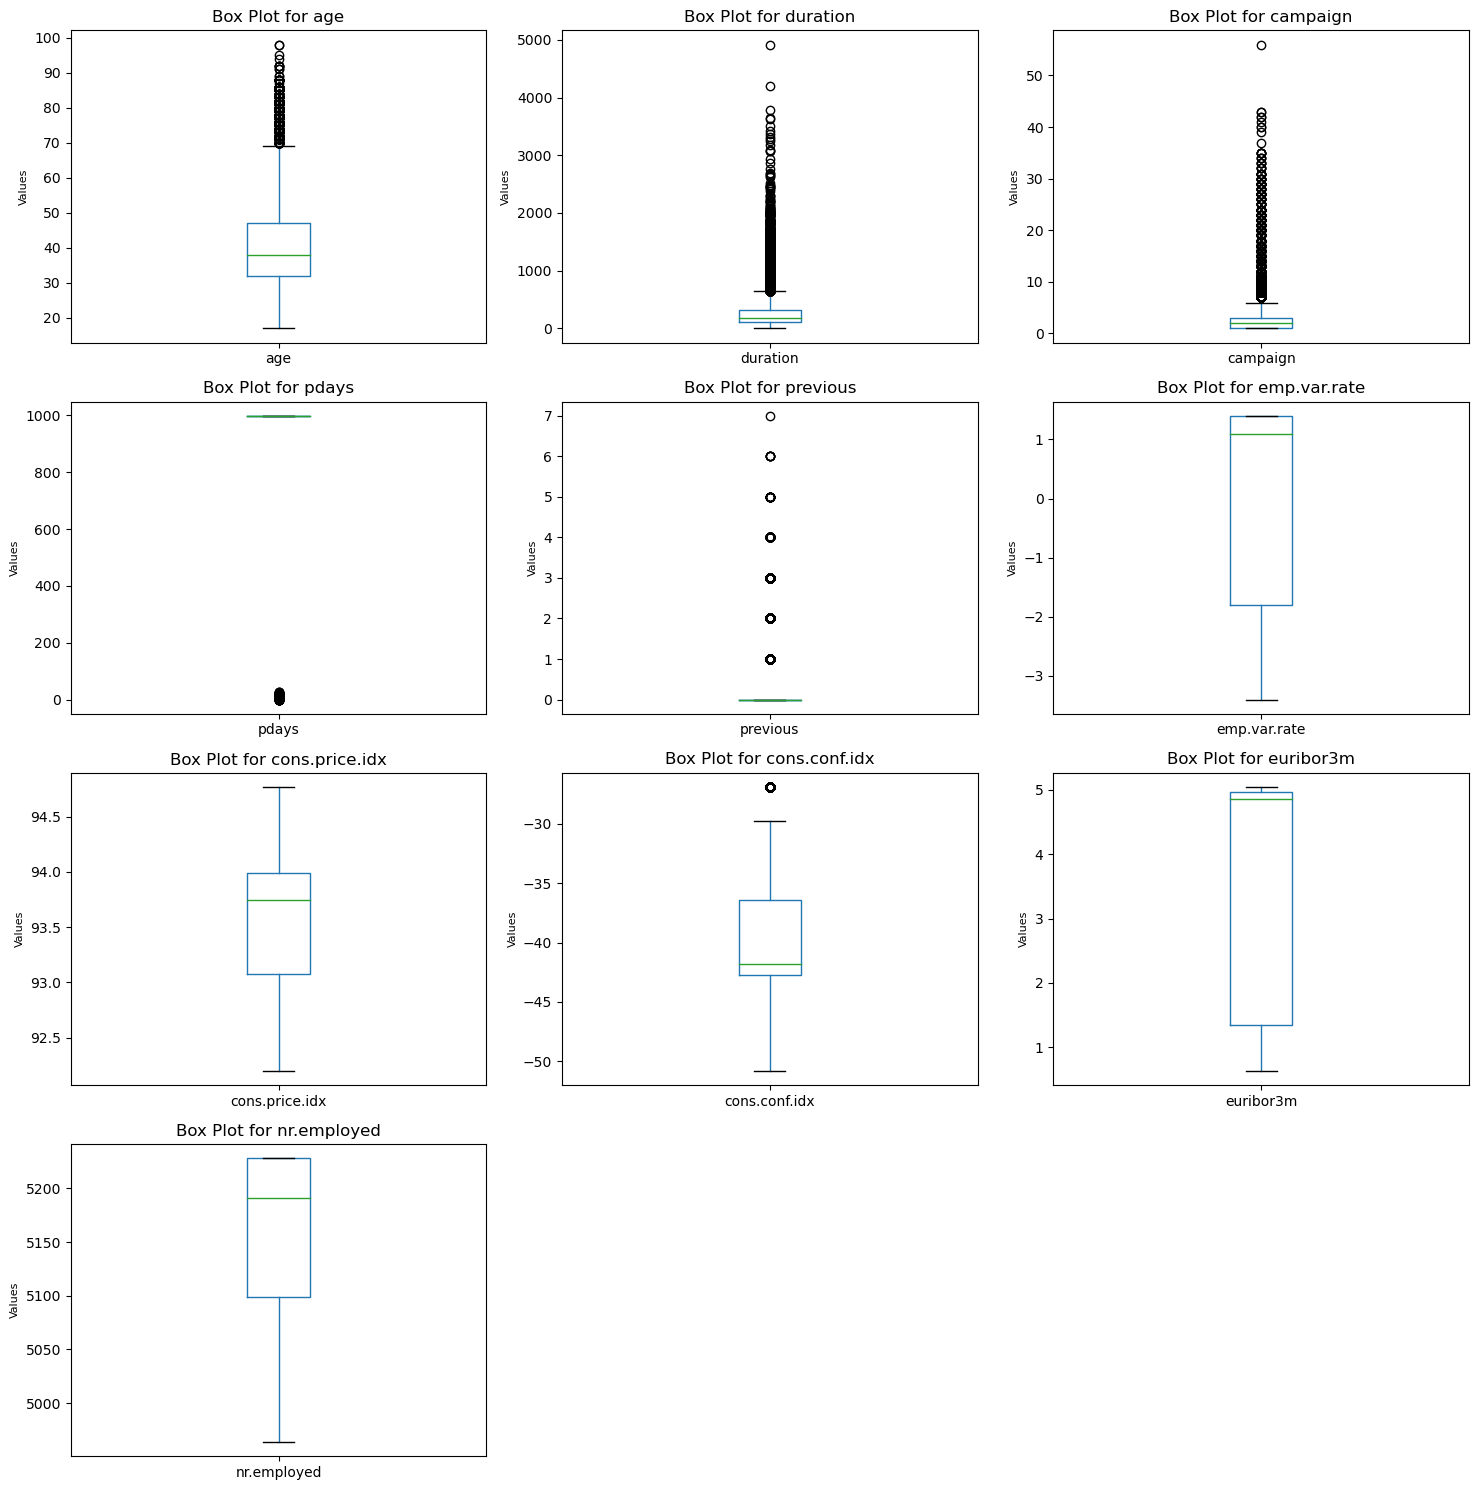

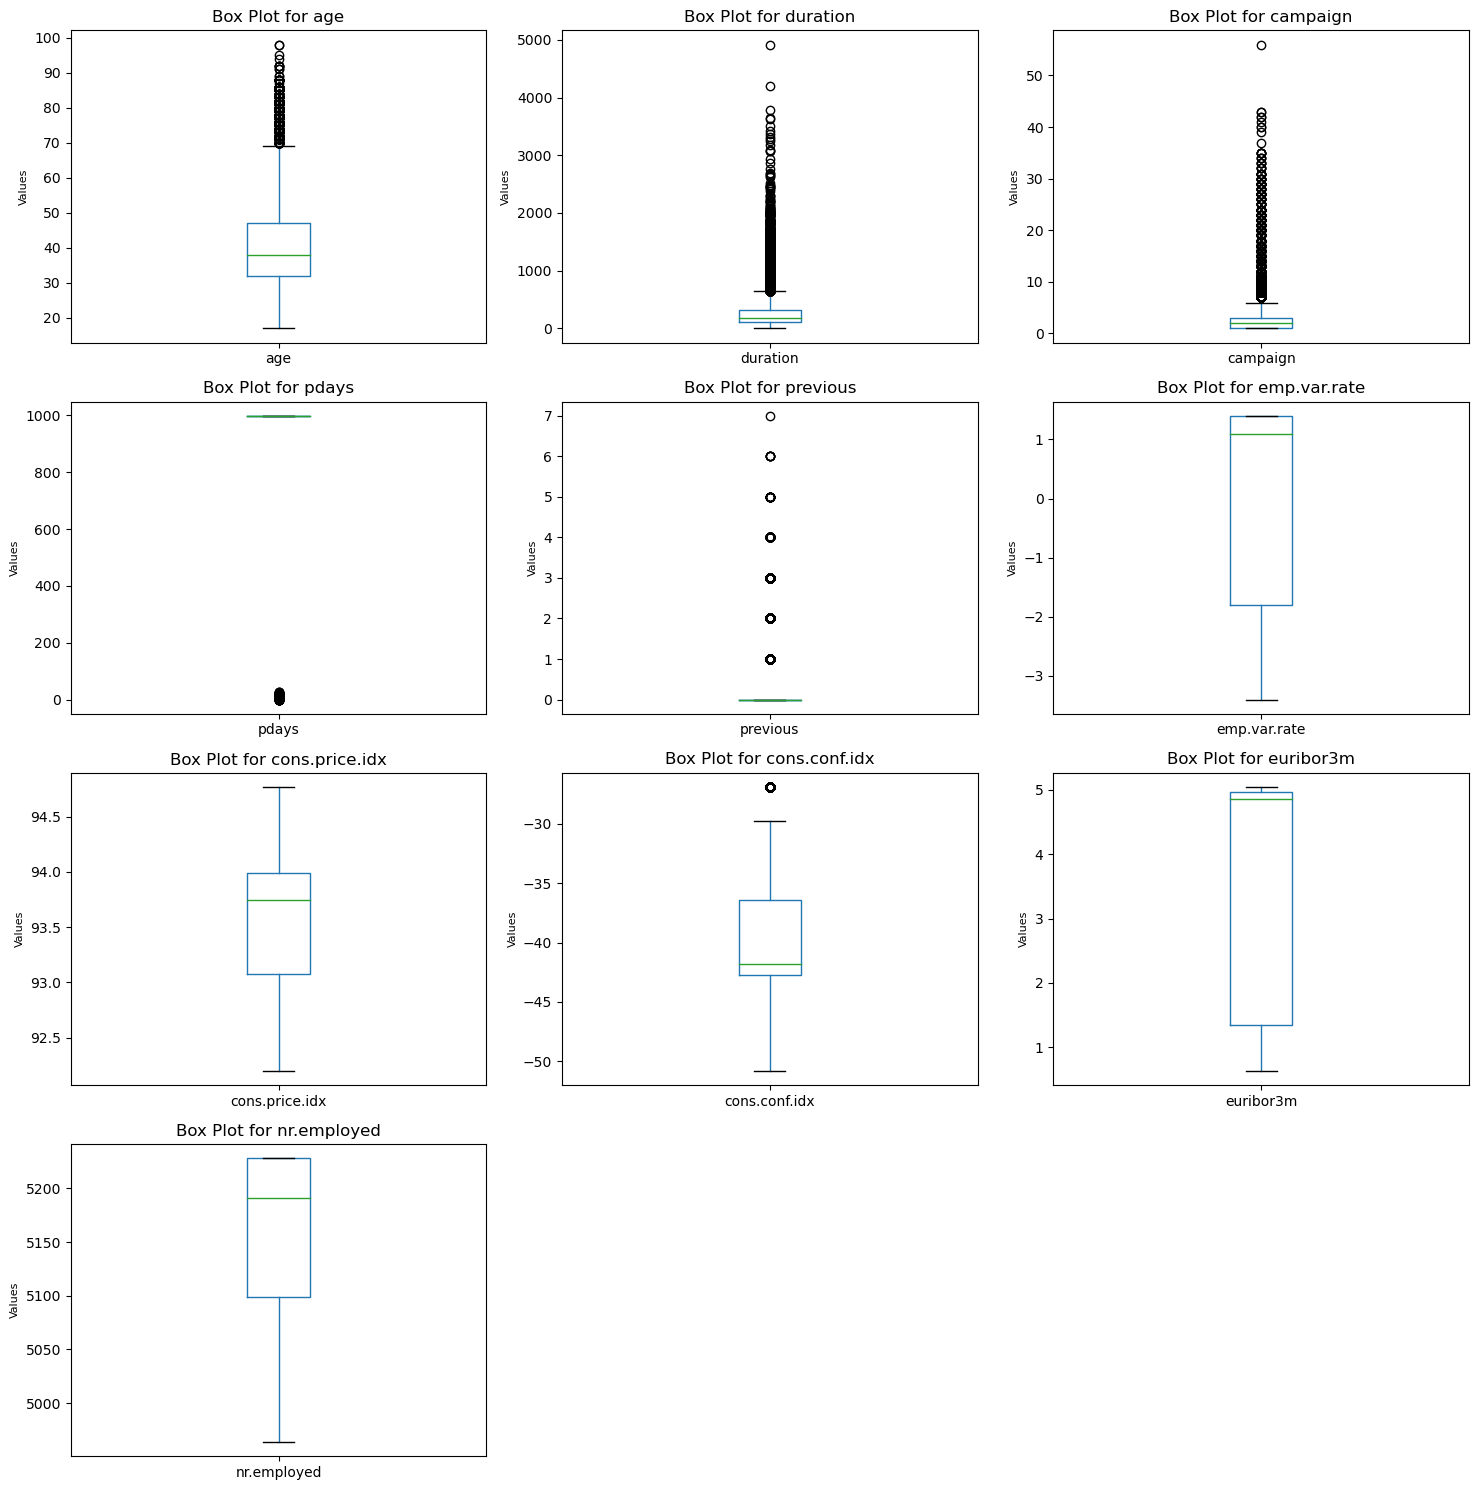

In [95]:
plot_boxs(raw_data_df)

In [49]:
def plot_correlations(dataframe: pd.DataFrame, target: str)-> matplotlib.figure.Figure:
    """
    Plot the target variabe vs the target variable while also getting correlation
    scores for each.

    Args:
    dataframe (pd.DataFrame): The data frame for which the histograms are to be
                                plotted.

    Returns:
    matplotlib.figure.Figure: The matplotlib figure object containing the
                                      plots.
    
    Note:
    Each histogram is normalized to show the frequency distribution of the values.
    """
    
    correlations = []
    features = []
    colours = []
    fig, axes = plt.subplots(figsize=(8, 6))
     
    for col in dataframe.columns:
        if col == target:
            continue

        if dataframe[col].dtype in ['float64', 'int64']:
     
            le = LabelEncoder()
            corr, _ = pointbiserialr(le.fit_transform(
                dataframe[target]), dataframe[col])
            correlations.append(abs(corr))
            features.append(col)
            colours.append('red')
        else:
            le = LabelEncoder()
            contingency_table = pd.crosstab(
                le.fit_transform(dataframe[target]), dataframe[col])
            chi2, _, _, _ = chi2_contingency(contingency_table)

            n = contingency_table.sum().sum()
            min_dim = min(contingency_table.shape) - 1 
            cramers_v = np.sqrt((chi2 / n) / min_dim)
            correlations.append(cramers_v)
            features.append(col)
            colours.append('blue')
    sns.barplot(x=correlations, y=features, ax=axes, palette=colours)
    legend_patches = [
        mpatches.Patch(color='red', label= 'Point Bi Serial - Continuous'),
        mpatches.Patch(color='blue', label='Crammers V - Categorical')
    ]

    plt.legend(handles=legend_patches)
    axes.set_title('Correlation Coefficients To Target')
    axes.set_xlabel('Correlation Coefficient')
    axes.set_ylabel('Variables')
    


    plt.tight_layout()
    

    return fig


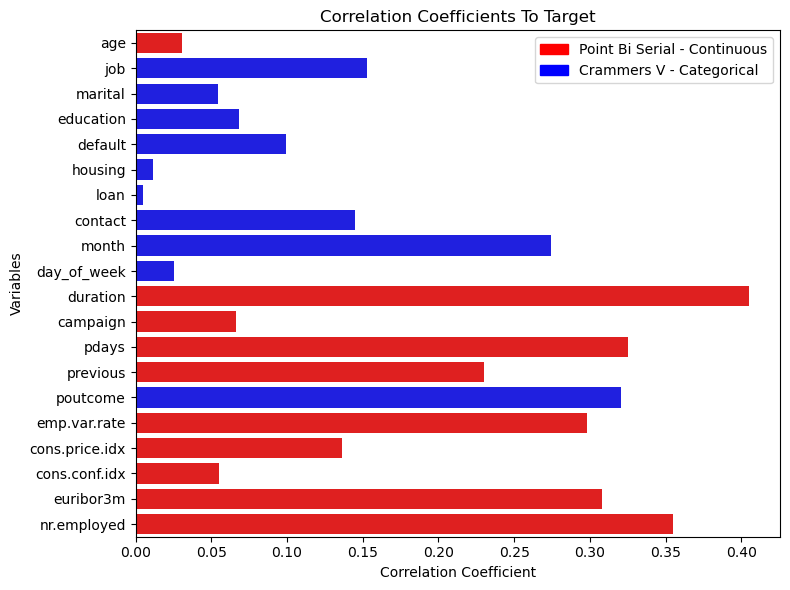

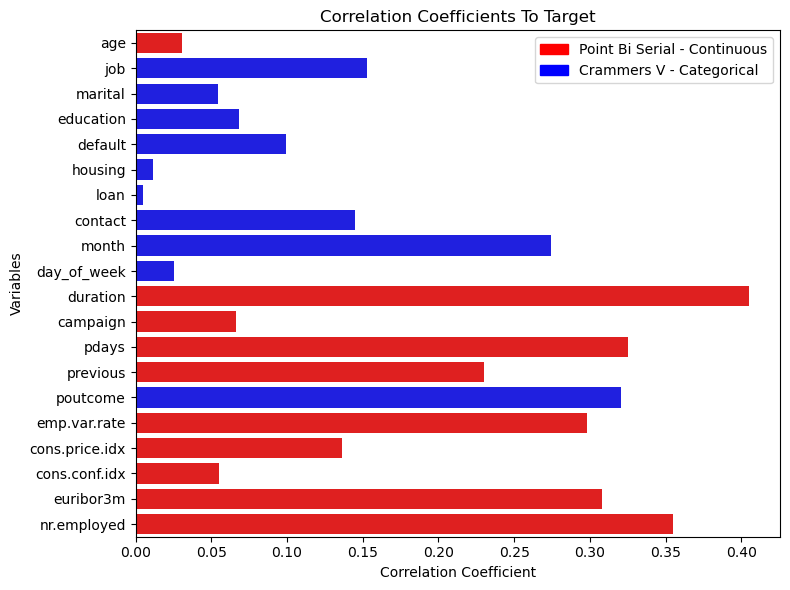

In [50]:
plot_correlations(raw_data_df, 'y')

Notes after initial EDA:
None of the variable appear to have a high cardinality so for any algorithms requiring encoding one hot can be used as memory usage should not be too high. 

The data set is massively imbalanced with 7.9 times the number of no values compared to yes, this class imbalance without adjusting for will certainly skew any algorithm to produce better results for no. 

The data set appears relatively clean, no nans are present and while unknown values exist in a few cases they could be a useful category for prediction. Trialling models with and without these would give greater insight.

For the correlation to the target two metrics had to be used depending on the nature of the comparison, point bi serial was chosen for continuous to binary and Crammers V for categorical to binary.

The correlation graphs identify five features with a corelation above 0.3 but on the whole no one feature appears to show a particularly strong correlation to the target suggesting a multitude will be needed. Note this may as be being impacted by the class imbalance at this stage. To test that the above was ran for a random sample of 4640 values from no to balance out the values from yes the results of which are below. 

The EDA shows us that not a huge amount of preproccessing may be required initially other than the encoding method for the categorical variables. The earlier mentioned issue with the large number of 999 values for pdays does not appear to be an anomoly and is potentially instead cases where no value is known so 999 has been used instead. As such this can be seen as a potential categorical flag and not ignored.

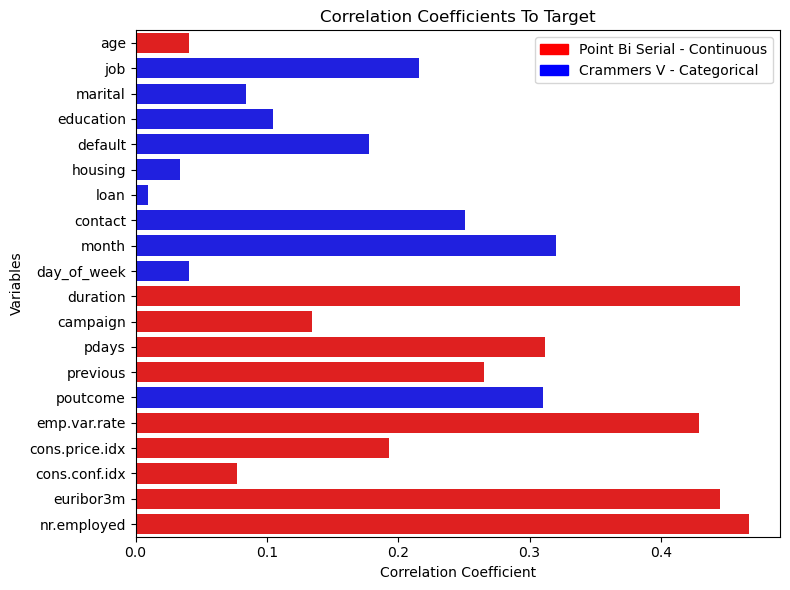

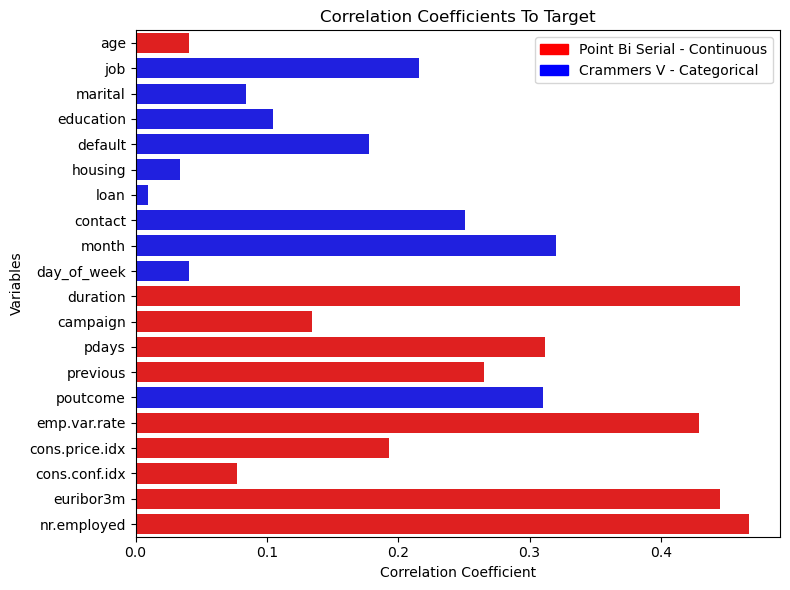

In [80]:
yes_class_count = raw_data_df['y'].value_counts().min()
balanced_data_df = raw_data_df.groupby('y').apply(lambda x: x.sample(yes_class_count)).reset_index(drop=True)
plot_correlations(balanced_data_df, 'y')

Correlations improve for many of the features, this backs up the theory from above. For future work a monte carlo method could be used to further test the hypothesis.

In [111]:
def calculate_cramers_v(contingency_table: pd.crosstab)-> float:
    """
    Calculate Cramer's V for a contingency table.

    Args:
        contingency_table (pd.crosstab): 
    
    Retunrns:
        float: Crammers V correlation value for variables.

    """
    chi2, _, _, _ = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

def plot_correlation_matrix(dataframe: pd.DataFrame) -> plt.Figure:
    """
    Plot a correlation matrix for all variables in the dataframe using appropriate metrics.

    Args:
        dataframe (pd.DataFrame): The dataframe for which the correlation matrix is to be plotted.

    Returns:
        plt.Figure: The matplotlib figure object containing the heatmap plot of the correlation matrix.
    """
    columns = dataframe.columns
    corr_matrix = pd.DataFrame(np.zeros((len(columns), len(columns))), columns=columns, index=columns)

    for col1 in columns:
        for col2 in columns:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = 1.0
            else:
                if dataframe[col1].dtype in ['float64', 'int64'] and dataframe[col2].dtype in ['float64', 'int64']:
                    corr, _ = pearsonr(dataframe[col1], dataframe[col2])
                elif dataframe[col1].dtype in ['float64', 'int64'] or dataframe[col2].dtype in ['float64', 'int64']:
                    if dataframe[col1].nunique() == 2 or dataframe[col2].nunique() == 2:
                        continuous = dataframe[col1] if dataframe[col1].dtype in ['float64', 'int64'] else dataframe[col2]
                        categorical = dataframe[col1] if dataframe[col1].dtype != ['float64', 'int64'] else dataframe[col2]
                        le = LabelEncoder()
                        corr, _ = pointbiserialr(continuous, le.fit_transform(categorical))
                    else:
                        corr = 0  
                else:
                    le = LabelEncoder()
                    contingency_table = pd.crosstab(le.fit_transform(dataframe[col1]), dataframe[col2])
                    corr = calculate_cramers_v(contingency_table)
                corr_matrix.loc[col1, col2] = corr

    fig, ax = plt.subplots(figsize=(20, 20))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr_matrix, cmap=cmap, vmax=1.0, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

    ax.set_title('Correlation Matrix of Variables')
    plt.tight_layout()

    return fig

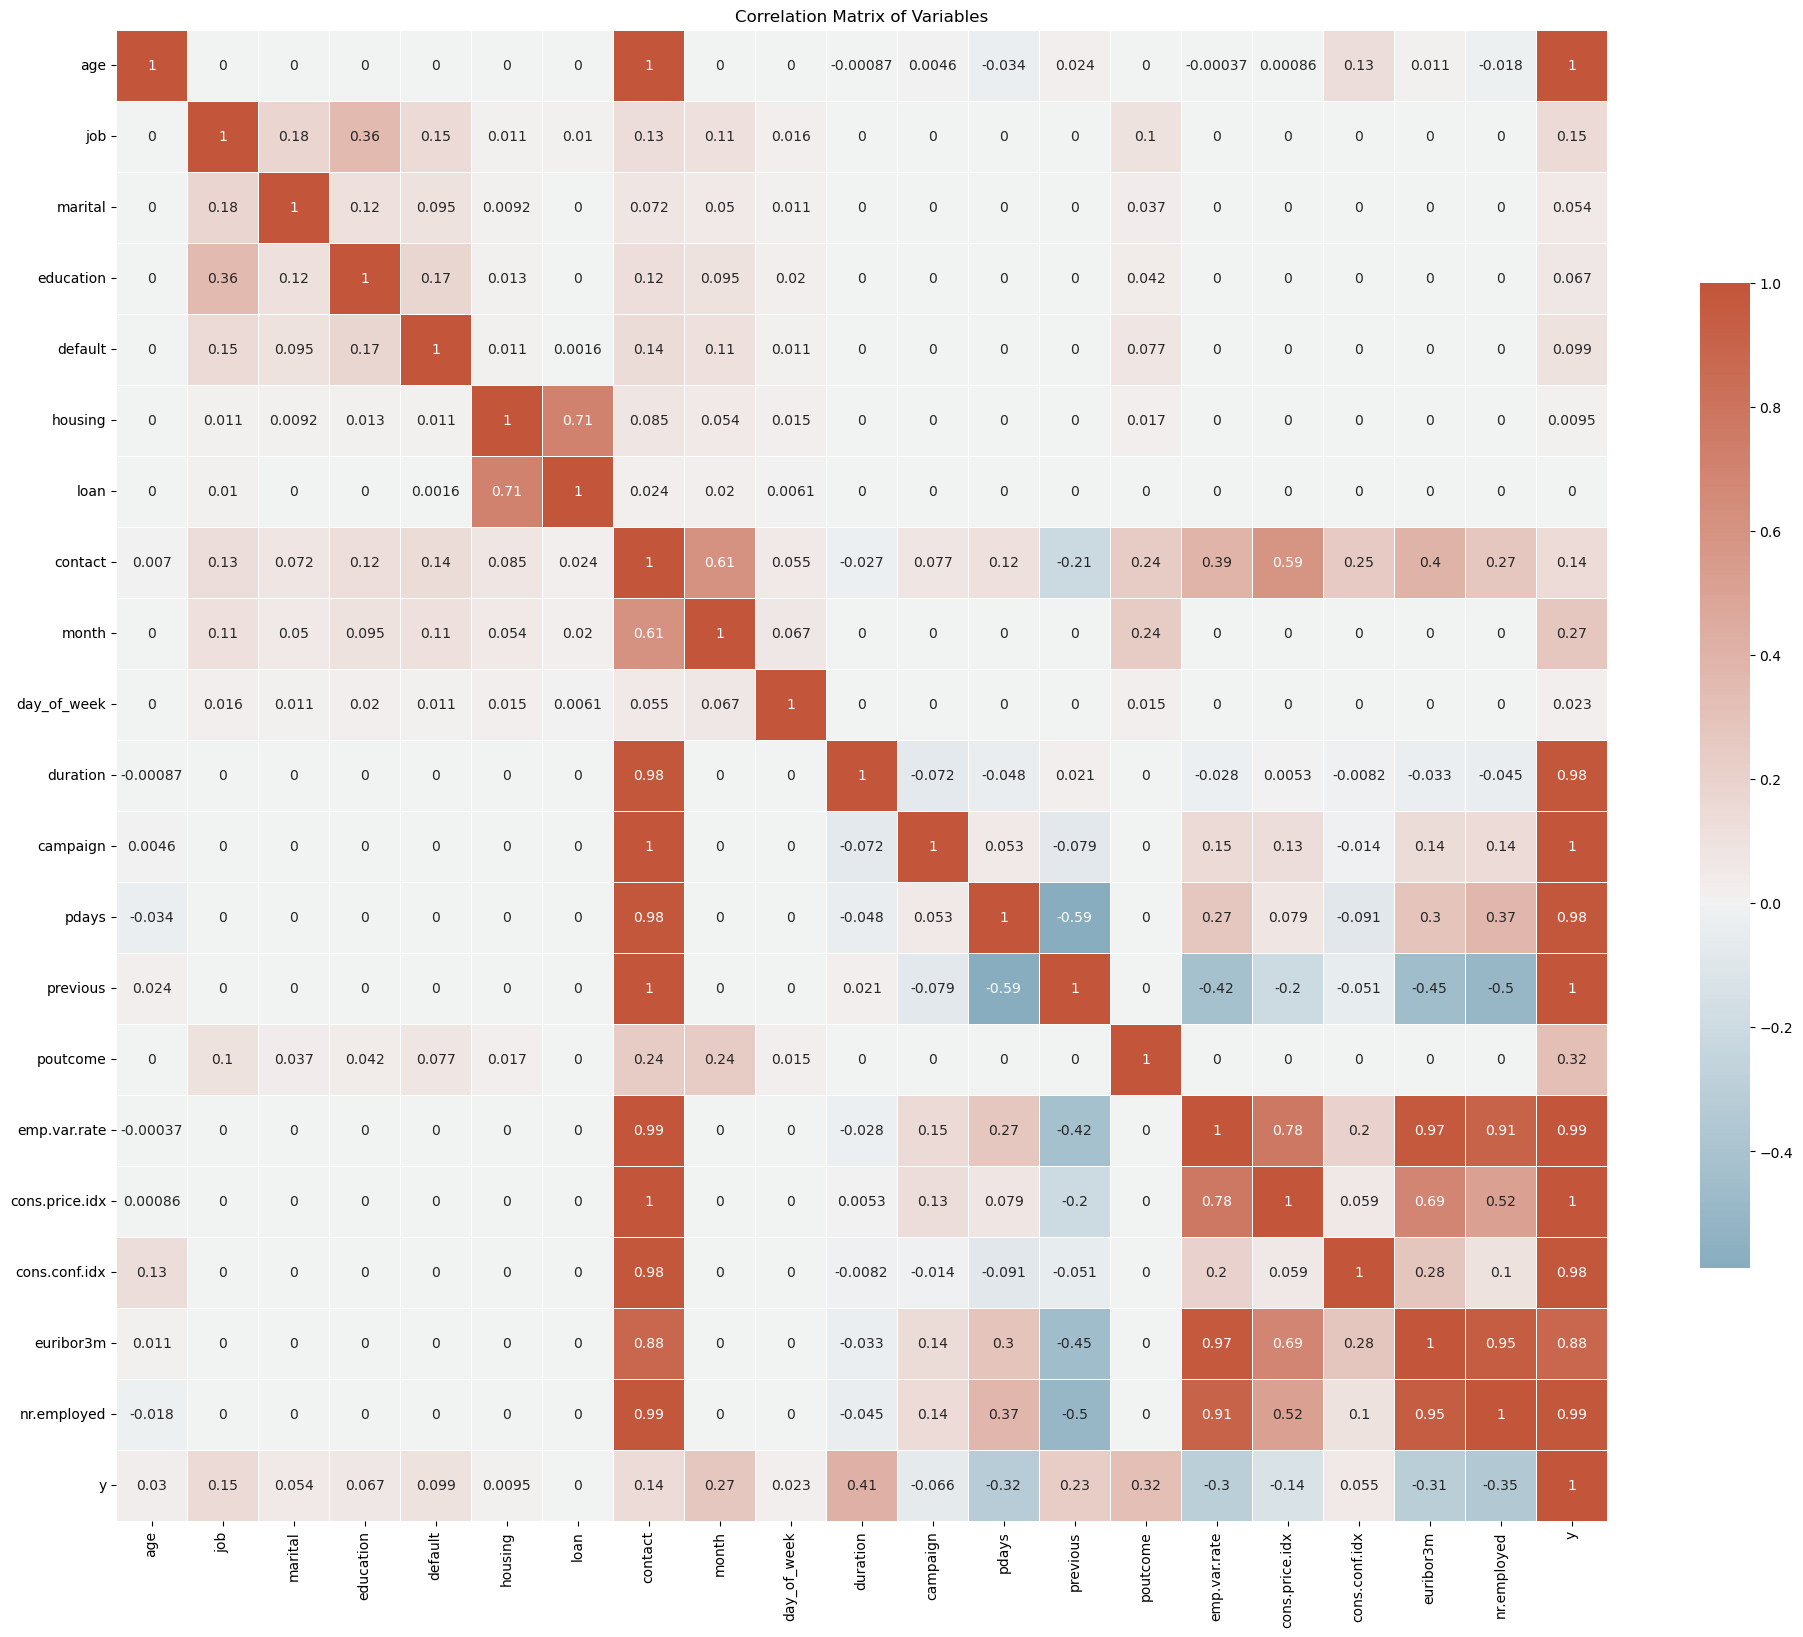

In [112]:

fig = plot_correlation_matrix(raw_data_df)
plt.show()

Above shows the correlation heatmap for all of the features again like earlier depending on the metrics being compared different correlation calculations have been used. The only addition here is the use of pearsons for comparing continuous values. Interestingly the target is correlating well to many of the features but not the reverse, suggesting the target could be used to predict these values. The other intersting correlation is the contact type, again this is binary so appears to correlate well with many of the features suggesting it could be used to predict the features it correlates well to aswell.